## import libraries, packages, data

### libraries, packages

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


### import clean data from part 1

In [2]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

In [3]:
df.columns

Index(['incident_date', 'incident_time', 'dispatched_time', 'call_taker',
       'dispatcher', 'dispatched_other', 'dispatched_situation',
       'arrival_time', 'available_time', 'complainant_street', 'officer',
       'equipment_number', 'impound_date', 'impound_time', 'location',
       'municipality', 'zip_code', 'species', 'breed', 'sex', 'size', 'color',
       'condition', 'temperment', 'disposition', 'disposition_date',
       'disposition_officer', 'service_type', 'inc_dt', 'imp_dt', 'weekday',
       'month'],
      dtype='object')

In [4]:
for col in ('month', 'weekday'):
    df[col] = df[col].astype(str)

In [5]:
df = df[['breed', 'size', 'color', 'month', 'species','municipality'
         , 'service_type', 'disposition']]

In [6]:
df.dropna(axis=0, inplace=True)

len(df)

# # assign target
y = df["disposition"]

#remove target from features
df.drop(columns= ['disposition'], axis=1, inplace=True)

# dummy categorical features
#col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(df.columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df, drop_first=True
                   , prefix=col_list))
X = df


39738

In [7]:

# X_train_d and y_train_d = using original standard test train spit dad
# that way, I can try out different resampling methods
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

### functions

In [8]:
# print model report
def model_report(model, cm = True): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
    
    if cm :

        cv_score = np.mean(cross_val_score(model, X, y, cv=3))
        print("cross val score: {:.4}%".format(cv_score * 100))

        print("\nClassification Report:")
        print(classification_report(actuals, predictions))

#         col_list = []
#         ind_list = []                     
#         for x in y_test.unique():
#             col_list.append('pred_'+ x)
#             ind_list.append('real_'+x)


        print('\nConfusion matrix:'.format(accuracy_score))
        display(pd.DataFrame(confusion_matrix(y_test, predictions)
                             #, columns=col_list, index=ind_list))
                ,columns=['pred doa','pred euth','pred spec_case', 'pred to owner','pred to wild', 'pred trans']
              , index=['real doa', 'real euth','real spec_case', 'real to owner', 'real to wild', 'real trans']))

    else:
        pass

In [9]:
def plot_matrix(classifier):

    disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                  display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true'
                                )


# def plot_matrix(model):

#     class_names = ['dead on arrival', 'euthanized', 'special case/other'
#                    , 'returned to owner', 'returned to wild', 'tranferred to CAA']

#     fig, ax = plot_confusion_matrix(model
# #                                     colorbar=True,
# #                                     show_absolute=False,
# #                                     show_normed=True,
# #                                     class_names=class_names
#                                    )
#     plt.show()

## feature importance according to chi2 and xtra trees

## prep data

### resampling

Due to the imbalance of class data, it could be beneficial to resample to compensate for the missing data. Using smote to oversample, then random undersampling is a common practice in these circumstances



In [10]:
over = SMOTE(
   sampling_strategy='not majority'
    , random_state=3)
under = RandomUnderSampler(
    sampling_strategy='not minority',
    random_state=3)
steps = [
    ('o', over),
     ('u', under)
]
pipeline = Pipeline(steps=steps)
# # transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [11]:
print (y_train.value_counts())

return_to_wild       23385
return_to_owner      23385
trans_caa            23385
dead_on_arrival      23385
special_caseother    23385
euthanized           23385
Name: disposition, dtype: int64


## __modeling__

The most challenging obstacle I anticipate is overfitting, and poor recall for the minority groups. 

__basic base model__

In [12]:
lr = LogisticRegression(random_state=3)
lr.fit(X_train, y_train)
 
# Predict on training set
predictions = lr.predict(X_test)
actuals = y_test

model_report(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Cross Validation Scoring:

train score: 66.32%
test score: 90.99%
cross val score: 92.51%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.00      0.00      0.00        27
  return_to_owner       0.00      0.00      0.00       305
   return_to_wild       0.84      1.00      0.91      1608
special_caseother       0.00      0.00      0.00       149
        trans_caa       0.93      0.96      0.95      5846

         accuracy                           0.91      7948
        macro avg       0.30      0.33      0.31      7948
     weighted avg       0.86      0.91      0.88      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,0,0,4,0,9
real euth,0,0,0,9,0,18
real spec_case,0,0,0,17,0,288
real to owner,0,0,0,1602,0,6
real to wild,0,0,0,61,0,88
real trans,0,0,0,216,0,5630


### decision tree

default model

In [13]:
# initialize and fit default decision tree
dt_model = DecisionTreeClassifier(random_state=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)
#actuals = y_test

model_report(dt_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')


Cross Validation Scoring:

train score: 98.52%
test score: 86.7%
cross val score: 88.68%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.07      0.05        27
  return_to_owner       0.12      0.15      0.13       305
   return_to_wild       0.91      0.96      0.94      1608
special_caseother       0.29      0.38      0.33       149
        trans_caa       0.93      0.90      0.91      5846

         accuracy                           0.87      7948
        macro avg       0.38      0.41      0.39      7948
     weighted avg       0.88      0.87      0.87      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,0,3,0,9
real euth,2,2,1,2,1,19
real spec_case,0,0,45,17,4,239
real to owner,5,7,9,1542,11,34
real to wild,1,1,3,11,56,77
real trans,12,35,318,114,121,5246


#### grid searching

In [14]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None]
max_features = [45,50,55]
max_depth = [60,80,100]
min_samples_split = [2,3,5]
min_samples_leaf = [2]
bootstrap = [True, False]

random_grid = {'criterion':criterion,
               'max_leaf_nodes': max_leaf_nodes,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# random grid search
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 50, cv = 3, verbose=3, error_score=0
                               , scoring=('recall_macro')
                               , random_state=3, n_jobs = -1)
# fit random search model
dt_random.fit(X_train, y_train);

print('best score: {:.4}%'.format(dt_random.best_score_ * 100));
print(dt_random.best_params_);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.9min finished


best score: 94.51%
{'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 55, 'max_depth': 100, 'criterion': 'entropy'}


__grid search__

In [15]:
# grid search params
param_grid_dt = {'criterion': ['gini', 'entropy'],
    'max_depth': [75,100,110],
    'min_samples_split': [2,3],
    'min_samples_leaf': [2],
     'max_features':['auto','sqrt',45,50,60],
     'max_leaf_nodes':[None]
        }

# grid search
gs_dt = GridSearchCV(estimator=dt_model,
                    param_grid=param_grid_dt,
                     error_score=0,
                    scoring=('recall_macro'),
                    cv=3, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train);

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100));
print('params:\n', gs_dt.best_params_);

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.7min finished


Best score: 94.6%
params:
 {'criterion': 'entropy', 'max_depth': 100, 'max_features': 60, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [16]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='gini',
                              max_depth=70,
                              max_features='sqrt',
                              max_leaf_nodes= None,
                               min_samples_leaf=1,
                               min_samples_split=2
                                
                                    )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### final model

In [17]:
model_report(dt_gs_model)


Cross Validation Scoring:

train score: 97.45%
test score: 85.54%
cross val score: 88.11%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.07      0.06        27
  return_to_owner       0.13      0.21      0.16       305
   return_to_wild       0.91      0.95      0.93      1608
special_caseother       0.23      0.26      0.24       149
        trans_caa       0.93      0.88      0.91      5846

         accuracy                           0.86      7948
        macro avg       0.37      0.40      0.38      7948
     weighted avg       0.88      0.86      0.87      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,3,3,0,6
real euth,1,2,3,3,0,18
real spec_case,0,0,63,17,2,223
real to owner,8,10,9,1535,12,34
real to wild,0,3,4,9,38,95
real trans,7,29,416,122,111,5161


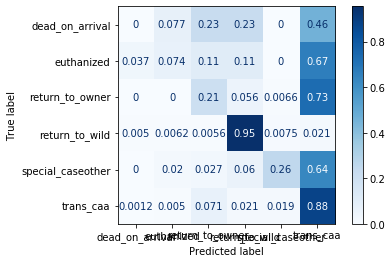

In [18]:
plot_matrix(dt_gs_model)

The test score didn't increase significantly, and the train score even decreased, but overfitting was avoided with the tuned model.

### Random Forest

---
__default model__

In [19]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
#actuals = y_test

model_report(rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


Cross Validation Scoring:

train score: 98.52%
test score: 89.32%
cross val score: 91.48%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.04      0.04        27
  return_to_owner       0.14      0.10      0.12       305
   return_to_wild       0.91      0.97      0.94      1608
special_caseother       0.38      0.38      0.38       149
        trans_caa       0.93      0.93      0.93      5846

         accuracy                           0.89      7948
        macro avg       0.40      0.40      0.40      7948
     weighted avg       0.88      0.89      0.89      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,0,3,1,8
real euth,1,1,0,4,1,20
real spec_case,0,0,30,17,3,255
real to owner,5,7,5,1555,9,27
real to wild,0,0,1,10,57,81
real trans,2,14,179,114,81,5456


#### grid searching

___
__Random Grid Search__

The default model is overfitting. Some ways to avoid overfitting with random forests are: increasing the n_estimators, reducing max features, limiting max depth, and increasing min leaf samples can help construct a more robust fit. Being that it did perform well despite the overfitting, I decided not to go crazy playing with the parameters.

In [20]:
# set random search params

n_estimators = [20,30,40,50,60]
min_weight_fraction_leaf=[0.0, 0.001, 0.0001]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [2,3,4,5,6]
min_impurity_split = [None]
min_impurity_decrease = [0.0,0.0001]
max_samples = [None]
max_leaf_nodes = [None]
max_features = ['auto', 7,8,15,20,50]
max_depth = [5,10,20,30,40,50,60]
criterion = ['entropy', 'gini']
bootstrap = [True, False]

# Create the random grid
random_grid = { 'n_estimators': n_estimators,
                 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'min_impurity_split': min_impurity_split,
                 'min_impurity_decrease': min_impurity_decrease,
                 'max_samples': max_samples,
                 'max_leaf_nodes': max_leaf_nodes,
                 'max_features': max_features,
                  'max_depth': max_depth,
                 'criterion': criterion,
                 'bootstrap': bootstrap
              }

# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 150, cv = 3, verbose=10
                               , scoring = 'recall_macro',random_state=1, n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

# print best parameters
print('best score: {:.4}%'.format(rf_random.best_score_ * 100));
print(rf_random.best_params_);

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 16

best score: 94.85%
{'n_estimators': 40, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 15, 'max_depth': 60, 'criterion': 'gini', 'bootstrap': True}


___
__grid search__

In [21]:
param_grid_rf = {
        'n_estimators': [40,50]
          , 'min_samples_leaf': [4]
         , 'min_samples_split':[3,4]
        , 'max_samples': [40,50]
        , 'max_leaf_nodes':[None]
           , 'max_features': [9,10]
         , 'max_depth': [40,50]
         , 'criterion': ['gini']
          , 'bootstrap': [False]
}

# grid search
gs_rf = GridSearchCV(estimator=rf_model
                    ,param_grid=param_grid_rf
                    ,cv=3,refit=True,error_score=0
                     , scoring='recall_macro', n_jobs=-1, verbose=5
                    )

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best score: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 17.6min finished


best score: 91.42%
params:
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': 40, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 50}


#### final model

___
__best model__

In [22]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                   bootstrap= False
                                    ,criterion= 'gini'
                                    , max_depth= 50
                                   , max_features = 9
                                   , max_leaf_nodes = None
                                   , max_samples = 50
                                     , min_samples_leaf = 4
                                   , min_samples_split = 4
                                    , n_estimators = 50
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);

# new model report
model_report(rf_gs_model)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=9,
                       max_leaf_nodes=None, max_samples=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Cross Validation Scoring:

train score: 92.44%
test score: 80.62%
cross val score: 91.82%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.33      0.07        27
  return_to_owner       0.15      0.43      0.23       305
   return_to_wild       0.91      0.97      0.94      1608
special_caseother       0.28      0.48      0.35       149
        trans_caa       0.96      0.79      0.87      5846

         accuracy                           0.81      7948
        macro avg       0.39      0.50      0.41      7948
     weighted avg       0.90      0.81      0.84      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,4,4,3,2,0
real euth,1,9,4,5,2,6
real spec_case,1,2,132,17,1,152
real to owner,0,12,1,1567,25,3
real to wild,1,12,4,5,72,55
real trans,41,183,717,122,155,4628


Train score went down, but test score and cross val score went up, so at least the tuning constructed a more robust model.

### AdaBoost

In [23]:
#initialize and fit default model
ada_model = AdaBoostClassifier(random_state=3)
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)
# actuals = y_test

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=3)

___
__Default Model__

In [ ]:
model_report(ada_model)


Cross Validation Scoring:

train score: 53.06%
test score: 61.8%
cross val score: 89.75%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.07      0.05        27
  return_to_owner       0.07      0.51      0.13       305
   return_to_wild       0.92      0.96      0.94      1608
special_caseother       0.08      0.37      0.13       149
        trans_caa       0.94      0.54      0.68      5846

         accuracy                           0.62      7948
        macro avg       0.34      0.41      0.32      7948
     weighted avg       0.88      0.62      0.70      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,0,0,3,4,6
real euth,0,2,1,1,16,7
real spec_case,0,1,157,16,1,130
real to owner,1,1,4,1550,51,1
real to wild,3,2,5,12,55,72
real trans,21,41,1931,105,600,3148


#### grid searching

__Random Grid Search__

In [ ]:
#set random search params
learning_rate= [.5, 1.0, 1.5]

n_estimators = [50,100, 200]

random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators
              }

In [ ]:
#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 5, cv = 3, verbose=2
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 344.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=3),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.5, 1.0, 1.5],
                                        'n_estimators': [50, 100, 200]},
                   pre_dispatch='2*n_jobs', random_state=3, refit=True,
                   return_train_score=False, scoring='recall_macro', verbose=2)

In [ ]:
ada_random.best_params_

{'n_estimators': 200, 'learning_rate': 0.5}

___
__grid search__

In [ ]:
#grid search params and fitting grid search
param_grid_ada = [
    {'n_estimators': [195,200,205],
    'learning_rate': [0.1, .9]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,
                    param_grid=param_grid_ada,
                    scoring='recall_macro',
                    cv=3, n_jobs=-1, verbose=10)

# Fit using grid search
gs_ada.fit(X_train, y_train)

# Best accuracy and parameters
print('best recall: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 25.1min remaining:  9.7min


In [ ]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=250,
                                   learning_rate=.11)
ada_gs_model.fit(X_train, y_train)

predictions = ada_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(ada_gs_model)

### gradient boost

In [ ]:
#initialize and fit gradient boost
gbt_model = GradientBoostingClassifier(random_state=3)
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
# actuals = y_test

__default model__

In [ ]:
#baseline model report
model_report(gbt_model)

__grid searching__

__random grid search__

In [ ]:
# setting parameters for random search
learning_rate=[0.05,.1, .15]
loss = ['deviance', 'exponential']
max_depth = [None] 
n_estimators = [90,100,110]
min_samples_split = [2,3]
min_samples_leaf = [1,2]
min_weight_fraction_leaf = [0,0.0001]

random_grid = {'learning_rate':learning_rate,
               'loss': loss,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_weight_fraction_leaf': min_weight_fraction_leaf
               }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model
                               , param_distributions = random_grid
                               , n_iter = 15, cv = 3, verbose=10
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train)

In [ ]:
print('best accuracy: {:.4}%'.format(gbt_random.best_score_ * 100));
print(gbt_random.best_params_)

__grid search__

In [ ]:
# grid search params and run search
param_grid_gbt = [
    {'n_estimators': [50,55],
     'min_weight_fraction_leaf':[0.001, 0.0001],
    'learning_rate': [0.1, .005],
    'min_samples_split': [2,3],
    'min_samples_leaf': [1,2],
    'max_depth': [None]
    }
]

# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,
                    param_grid=param_grid_gbt,
                    scoring='recall_macro',
                    cv=3, n_jobs=-1, verbose=10)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best accuracy: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

In [ ]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.1,
                                         max_depth=2,
                                         min_samples_leaf=2,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.01,
                                         n_estimators=60)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
# new model report
model_report(gbt_gs_model)

### SVM

In [ ]:
svm_model = svm.SVC(random_state=3)
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)
# actuals = y_test

___
__default model__

In [ ]:
model_report(svm_model, cm=False)

#### grid searching

__random grid search__

In [ ]:
# set random search params
clf_C = [0.07,0.1,1.0, 1.03]
clf_gamma = [0.005,0.001,0.01, 0.1]
clf_kernel = ['rbf', 'linear']

random_grid = {
               'C': clf_C,
               'gamma': clf_gamma,
               'kernel': clf_kernel
               }

# fit and search random param combinations
svm_random = RandomizedSearchCV(estimator = svm_model
                               , param_distributions = random_grid
                               , n_iter = 8 , cv = 3, verbose=10
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)

In [ ]:
print('best accuracy: {:.4}%'.format(svm_random.best_score_ * 100));
print(svm_random.best_params_)

___
__grid search__

In [ ]:
# Set grid search params
param_grid_svm = [
 
  {'C': [1.0, 1.01, 1.03], 'gamma': [0.008, 0.01, 0.012]
   , 'kernel': ['rbf', 'linear']
  }]
 

# Construct grid search
gs_svm = GridSearchCV(estimator=svm_model,
            param_grid=param_grid_svm,scoring='recall_macro',
            cv=5, verbose=10, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('best score: {:.4}%'.format(gs_svm.best_score_ * 100));
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
svm_gs_model = svm.SVC(C=1.03
                       ,gamma=0.008
                        ,kernel='rbf'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(svm_gs_model, cm=False)

### XGBoost

In [ ]:
# initiate model
xgb_model = XGBClassifier(random_state=3)
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
# actuals = y_test

In [ ]:
model_report(xgb_model)

#### grid searching

__random grid search__

In [ ]:
#set random search params
learning_rate=[.1,.11]
max_depth = [3]
min_child_weight = [1, 1.1]
n_estimators = [90,100,110]


random_grid = {
               'learning_rate':learning_rate,
               'max_depth': max_depth,
               'min_child_weight':min_child_weight
              'n_estimators': n_estimators
              }

# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model
                               , param_distributions = random_grid
                               , n_iter = 5, cv = 3, verbose=10, scoring='recall_macro'
                               , random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)
print('best accuracy: {:.4}%'.format(xgb_random.best_score_ * 100));
print(xgb_random.best_params_);

#### grid search

In [ ]:
param_grid_xgb = [
    {
        'xgb_model__min_child_weight': [0.9, 1.0, 1.1],
    'xgb_model__learning_rate': [.09,.1],
    'xgb_model__n_estimators': [90,95]
 }
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid_xgb,
                    scoring='recall_macro',random_state=3,
                    cv=3, n_jobs=-1, verbose=10)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_);

In [ ]:
# fit using best params
xgb_gs_model = XGBClassifier(learning_rate=0.009,
                           #  max_depth=3,
                             min_child_weight=1
                          #   n_estimators=90
                            )
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)

model_report(xgb_gs_model)